In [1]:
from __future__ import print_function
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Input, Reshape
from keras.layers import Conv2D, UpSampling2D, BatchNormalization
from keras.layers.advanced_activations import LeakyReLU
from keras.utils import to_categorical
from keras.models import Model
from keras.callbacks import EarlyStopping
from keras import backend as K
import numpy as np
import pickle

Using TensorFlow backend.


In [23]:
with open('data2.pkl', 'rb') as f:
    x_train = pickle.load(f)
x_train = x_train.astype('float32')
x_train /= 255

In [43]:
m = 4; n = 1; k = 35;
X_train = np.zeros((x_train.shape[0]-k-m, x_train.shape[1], x_train.shape[2], x_train.shape[3], m));
Y_train = np.zeros((x_train.shape[0]-k-m, x_train.shape[1], x_train.shape[2], x_train.shape[3]));
X_test = np.zeros((k, x_train.shape[1], x_train.shape[2], x_train.shape[3], m));
Y_test = np.zeros((k, x_train.shape[1], x_train.shape[2], x_train.shape[3]));
for i in range(x_train.shape[0]-m-k):
    for j in range(m):
        X_train[i,:,:,:,j] = x_train[i+j]
    Y_train[i] = x_train[i+m]
for i in range(x_train.shape[0]-m-k, x_train.shape[0]-m):
    for j in range(m):
        X_test[i-x_train.shape[0]+m+k,:,:,:,j] = x_train[i+j]
    Y_test[i-x_train.shape[0]+m+k] = x_train[i+m]

X_train = np.reshape(X_train, [X_train.shape[0], X_train.shape[1], X_train.shape[2], X_train.shape[3]*m])
X_test = np.reshape(X_test, [X_test.shape[0], X_test.shape[1], X_test.shape[2], X_test.shape[3]*m])

In [58]:
input_d = Input(shape = (144, 256, 3*m,))
layerd1 = Conv2D(64, (3, 3), strides = (2, 2), padding = 'same', activation='relu') (input_d)
layerd1 = BatchNormalization(momentum=0.8)(Dropout(0.25)(LeakyReLU(alpha=0.2)(layerd1)))
layerd1 = UpSampling2D()(layerd1)

layerd2 = Conv2D(64, (3, 3), strides = (2, 2), padding = 'same', activation='relu') (layerd1)
layerd2 = BatchNormalization(momentum=0.8)(Dropout(0.25)(LeakyReLU(alpha=0.2)(layerd2)))
layerd2 = UpSampling2D()(layerd2)

layerd3 = Conv2D(64, (3, 3), strides = (2, 2), padding = 'same', activation='relu') (layerd2)
layerd3 = BatchNormalization(momentum=0.8)(Dropout(0.25)(LeakyReLU(alpha=0.2)(layerd3)))
layerd3 = UpSampling2D()(layerd3)

output = Conv2D(3, (3, 3), padding = 'same', activation='relu') (layerd3)

model_d = Model(inputs=input_d, outputs=output);

In [59]:
model_d.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 144, 256, 12)      0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 72, 128, 64)       6976      
_________________________________________________________________
up_sampling2d_10 (UpSampling (None, 144, 256, 64)      0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 72, 128, 64)       36928     
_________________________________________________________________
up_sampling2d_11 (UpSampling (None, 144, 256, 64)      0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 72, 128, 64)       36928     
_________________________________________________________________
up_sampling2d_12 (UpSampling (None, 144, 256, 64)      0         
__________

In [60]:
model_d.compile(loss='binary_crossentropy',
            optimizer='adam', metrics=['accuracy'])

In [61]:
stopper = EarlyStopping(monitor='acc',
                              min_delta=0,
                              patience=0,
                              verbose=1, mode='auto')
model_d.fit(X_train, Y_train, 
          batch_size=8, epochs=10, callbacks=[stopper], verbose=1)

Epoch 1/10
85/85 [==============================] - 3s 41ms/step - loss: 0.5436 - acc: 9.6029e-04
Epoch 2/10
85/85 [==============================] - 2s 28ms/step - loss: 0.4845 - acc: 9.4103e-04
Epoch 00002: early stopping


In [62]:
Yhat_test = model_d.predict(X_test)

In [63]:
Y_test.shape

(35, 144, 256, 3)

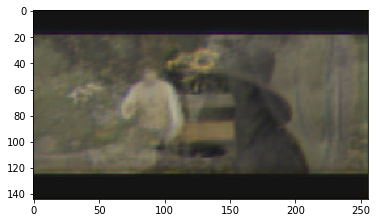

In [70]:
import matplotlib.pyplot as plt
plt.imshow(Yhat_test[8,:,:,:])